In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import os

import torch
import torchvision
import torchvision.transforms as T
import splitfolders
from torch.utils.data import DataLoader

## Load data

In [2]:
train_path = "C:/Users/User/Documents/traindata/traindata"
train_data = torchvision.datasets.ImageFolder(root=train_path)

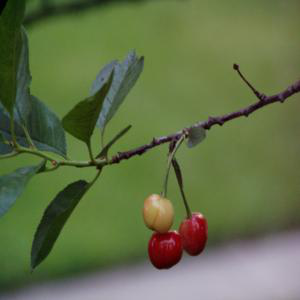

In [3]:
train_data[0][0] 

In [4]:
transform = T.Compose([T.ToTensor()])

train1 = torchvision.datasets.ImageFolder(root=train_path, transform=transform)

train1

Dataset ImageFolder
    Number of datapoints: 4500
    Root location: C:/Users/User/Documents/traindata/traindata
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [5]:
train1[1500][0].shape

torch.Size([3, 300, 300])

## Load cleaned data

In [6]:
train_path_cleaned = "C:/Users/User/Documents/COMP309/traindataclean"
train_data_cleaned = torchvision.datasets.ImageFolder(root=train_path_cleaned)

In [7]:
transform1 = T.Compose([T.ToTensor()])

train2 = torchvision.datasets.ImageFolder(root=train_path_cleaned, transform=transform1)

train2

Dataset ImageFolder
    Number of datapoints: 4350
    Root location: C:/Users/User/Documents/COMP309/traindataclean
    StandardTransform
Transform: Compose(
               ToTensor()
           )

## Split to train and validation set

In [8]:
splitfolders.ratio("C:/Users/User/Documents/COMP309/traindataclean", output="trainset", seed=1337, ratio=(0.8, 0.2))

Copying files: 4350 files [00:18, 240.73 files/s]


In [9]:
train_path2 = "trainset/train"
val_path2  = "trainset/val"

In [10]:
def loadData():
    train_T = T.Compose([T.Resize((32,32)),
                         T.RandomRotation(90),
                         T.RandomHorizontalFlip(),
                         T.ToTensor()])
    
    val_T   = T.Compose([T.Resize((32,32)),
                         T.ToTensor()])
    
    train_data = torchvision.datasets.ImageFolder(train_path2, transform=train_T)
    val_data   = torchvision.datasets.ImageFolder(val_path2 , transform=val_T)  
    
    return train_data, val_data 


In [11]:
train_set, val_set = loadData()

In [12]:
train_set[0][0].shape

torch.Size([3, 32, 32])

In [20]:
N = 30
batch_size = 16
train_dl = DataLoader(train_set, batch_size, shuffle=True)
val_dl   = DataLoader(val_set,   batch_size, shuffle=True)

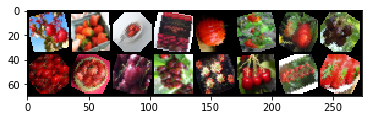

cherry strawberry tomato cherry tomato tomato strawberry cherry cherry strawberry cherry cherry tomato cherry tomato strawberry


In [14]:
def imshow(image):
    image=image 
    npimg= image.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)))
    plt.show()
    
# 1 group of data is randomly chosen to display the picture
dataiter= iter(train_dl)
images, labels = dataiter.next()

imshow(torchvision.utils.make_grid(images))

classes =['cherry','strawberry','tomato']

print(' '.join(f'{classes[labels[i]]:5s}' for i in range(batch_size)))

### Initial design - MLP

### Define the model

In [15]:
import torch.nn as nn

class Classifier(nn.Module):
    def train_step(self, batch):
        imgs, labs = batch 
        pred = self(imgs)                  # Generate predictions
        loss = F.cross_entropy(pred, labs) # Calculate loss
        acc  = accuracy(pred, labs)        # Calculate accuracy
        return loss, acc
    
    def val_step(self, batch):
        imgs, labs = batch 
        pred = self(imgs)                    # Generate predictions
        loss = F.cross_entropy(pred, labs)   # Calculate loss
        acc  = accuracy(pred, labs)          # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def val_epoch(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss   = torch.stack(batch_losses).mean()  # Combine losses
        
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc  = torch.stack(batch_accs).mean()      # Combine accuracies
        
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def show(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, train_acc: {:.4f}, val_acc: {:.4f}"
              .format(epoch, result['train_loss'], result['val_loss'], result['train_acc'], result['val_acc']))

In [16]:
class MLP(Classifier):   
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(           
            nn.Flatten(),
            nn.Linear(32*32*3, 64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,3),
            nn.Softmax()
        )
        
    def forward(self, x):
        return self.layers(x);

In [17]:
def accuracy(outputs, labs):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labs).item() / len(preds))

@torch.no_grad()      #since we're not training, we don't need to calculate the gradients for our outputs
def evaluate(model, val_loader):
    model.eval()      #turn it off during model evaluation, .eval() do it .
    outputs = [model.val_step(batch) for batch in val_loader]
    return model.val_epoch(outputs)

  
def fitModel(epochs, model, optimizer, train_loader, val_loader):
    history = []
    S = dt.datetime.now()
    for epoch in range(1, epochs+1):
        
        model.train()                 # turn back to training mode after eval step
        train_losses = []             # just to show a plot later...
        train_accs   = []
        
        # Training phase
        for batch in train_loader:
            loss, acc = model.train_step(batch)
            train_losses.append(loss)
            train_accs.append(acc)
            
            loss.backward()            # backpropagate the loss
            optimizer.step()           # adjust parameters based on the calculated gradients
            optimizer.zero_grad()      # Gradients accumulate by default, so don't forget to do this.
         
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()    #COMBINE LOSS
        result['train_acc'] = torch.stack(train_accs).mean().item()       # COMBINE ACC
        model.show(epoch, result)
        history.append(result)
        
    E = dt.datetime.now()
    print("\nExecution time:", round((E-S).total_seconds()/60, 2), "mins")
    
    return history


In [18]:
import torch.optim as optim

m1 = MLP()
m2 = MLP()
m3 = MLP()

optim1 = optim.SGD(m1.parameters(), lr=0.001)
optim2 = optim.RMSprop(m2.parameters(), lr=0.001)
optim3 = optim.Adam(m3.parameters(), lr=0.001)

In [21]:
import datetime as dt
import torch.nn.functional as F


hist1 = fitModel(N, m1, optim1, train_dl, val_dl)

Epoch [1], train_loss: 1.0976, val_loss: 1.0972, train_acc: 0.3337, val_acc: 0.3333
Epoch [2], train_loss: 1.0972, val_loss: 1.0969, train_acc: 0.3331, val_acc: 0.3333
Epoch [3], train_loss: 1.0966, val_loss: 1.0964, train_acc: 0.3334, val_acc: 0.3333
Epoch [4], train_loss: 1.0964, val_loss: 1.0960, train_acc: 0.3329, val_acc: 0.3333
Epoch [5], train_loss: 1.0963, val_loss: 1.0956, train_acc: 0.3372, val_acc: 0.3345
Epoch [6], train_loss: 1.0957, val_loss: 1.0953, train_acc: 0.3360, val_acc: 0.3345
Epoch [7], train_loss: 1.0954, val_loss: 1.0950, train_acc: 0.3369, val_acc: 0.3379
Epoch [8], train_loss: 1.0951, val_loss: 1.0943, train_acc: 0.3389, val_acc: 0.3432
Epoch [9], train_loss: 1.0949, val_loss: 1.0941, train_acc: 0.3455, val_acc: 0.3443
Epoch [10], train_loss: 1.0946, val_loss: 1.0939, train_acc: 0.3458, val_acc: 0.3538
Epoch [11], train_loss: 1.0941, val_loss: 1.0934, train_acc: 0.3498, val_acc: 0.3625
Epoch [12], train_loss: 1.0940, val_loss: 1.0931, train_acc: 0.3584, val_a

In [22]:
hist2 = fitModel(N, m2, optim2, train_dl, val_dl)

Epoch [1], train_loss: 1.0907, val_loss: 1.0753, train_acc: 0.3913, val_acc: 0.4091
Epoch [2], train_loss: 1.0672, val_loss: 1.0576, train_acc: 0.4240, val_acc: 0.4534
Epoch [3], train_loss: 1.0558, val_loss: 1.0318, train_acc: 0.4407, val_acc: 0.4792
Epoch [4], train_loss: 1.0461, val_loss: 1.0283, train_acc: 0.4627, val_acc: 0.4989
Epoch [5], train_loss: 1.0388, val_loss: 1.0327, train_acc: 0.4788, val_acc: 0.4966
Epoch [6], train_loss: 1.0318, val_loss: 1.0223, train_acc: 0.4905, val_acc: 0.5129
Epoch [7], train_loss: 1.0257, val_loss: 1.0299, train_acc: 0.4940, val_acc: 0.4822
Epoch [8], train_loss: 1.0265, val_loss: 1.0249, train_acc: 0.4951, val_acc: 0.4932
Epoch [9], train_loss: 1.0247, val_loss: 1.0635, train_acc: 0.4951, val_acc: 0.4595
Epoch [10], train_loss: 1.0252, val_loss: 1.0118, train_acc: 0.4897, val_acc: 0.4996
Epoch [11], train_loss: 1.0155, val_loss: 1.0062, train_acc: 0.5109, val_acc: 0.5136
Epoch [12], train_loss: 1.0181, val_loss: 1.0256, train_acc: 0.5017, val_a

In [23]:
hist3 = fitModel(N, m3, optim3, train_dl, val_dl)

Epoch [1], train_loss: 1.0926, val_loss: 1.0824, train_acc: 0.3690, val_acc: 0.3860
Epoch [2], train_loss: 1.0667, val_loss: 1.0473, train_acc: 0.4212, val_acc: 0.4470
Epoch [3], train_loss: 1.0506, val_loss: 1.0617, train_acc: 0.4458, val_acc: 0.4428
Epoch [4], train_loss: 1.0415, val_loss: 1.0657, train_acc: 0.4676, val_acc: 0.4405
Epoch [5], train_loss: 1.0422, val_loss: 1.0205, train_acc: 0.4771, val_acc: 0.5098
Epoch [6], train_loss: 1.0314, val_loss: 1.0410, train_acc: 0.4908, val_acc: 0.4674
Epoch [7], train_loss: 1.0289, val_loss: 1.0332, train_acc: 0.4776, val_acc: 0.4742
Epoch [8], train_loss: 1.0277, val_loss: 1.0117, train_acc: 0.4871, val_acc: 0.4966
Epoch [9], train_loss: 1.0240, val_loss: 1.0054, train_acc: 0.4951, val_acc: 0.5265
Epoch [10], train_loss: 1.0223, val_loss: 1.0226, train_acc: 0.4966, val_acc: 0.4784
Epoch [11], train_loss: 1.0169, val_loss: 1.0151, train_acc: 0.4951, val_acc: 0.5174
Epoch [12], train_loss: 1.0123, val_loss: 1.0280, train_acc: 0.5140, val_a

In [24]:
def plotGraphs(df):
    fig, ax = plt.subplots(1,2, figsize=(24, 10), dpi=70)
    plt.tight_layout(pad = 8.0)

    ax[0].plot(df['train_loss'])
    ax[0].plot(df['val_loss'])
    ax[0].set(title = 'LOSS', xlabel = 'epochs', ylabel = '^')
    ax[0].legend(["Train", "Validation"], loc='upper right')
    
    ax[1].plot(df['train_acc'])
    ax[1].plot(df['val_acc'])
    ax[1].set(title = 'ACCURACY', xlabel = 'epochs', ylabel = '%')
    ax[1].legend(["Train", "Validation"], loc='lower right')
    
    plt.show()

In [25]:
M0_hist1 = pd.DataFrame(hist1)
M0_hist2 = pd.DataFrame(hist2)
M0_hist3 = pd.DataFrame(hist3)

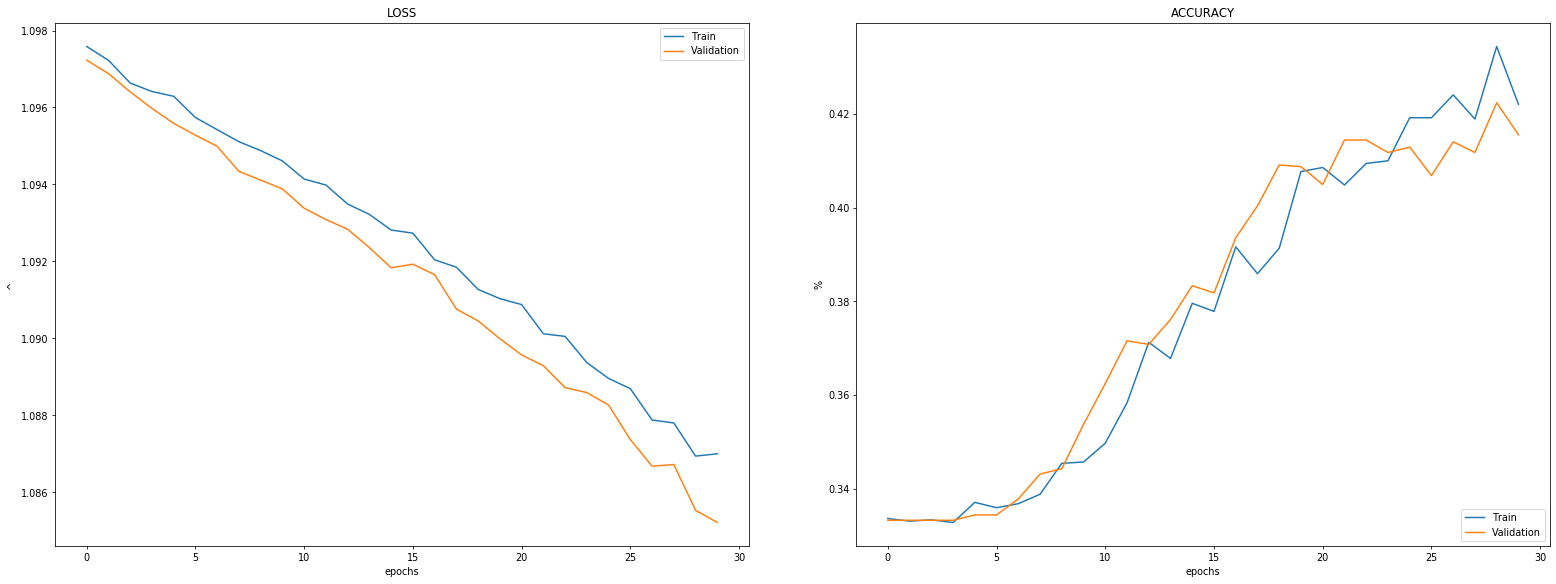

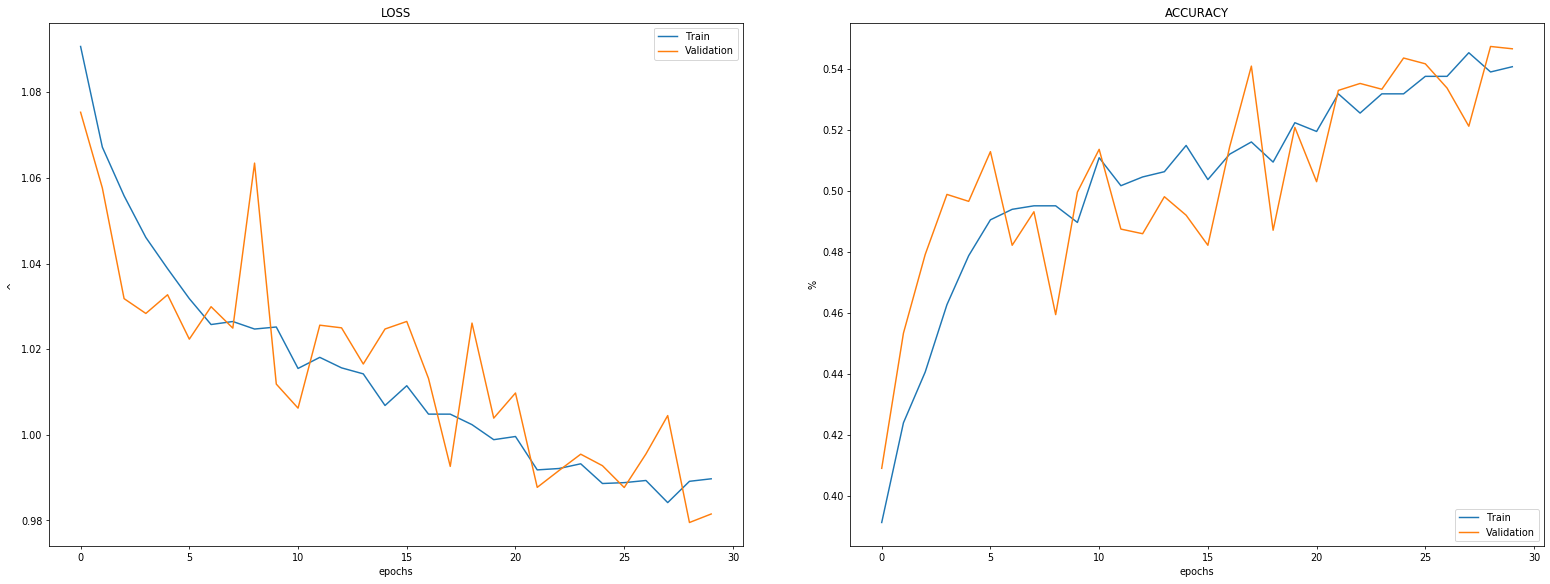

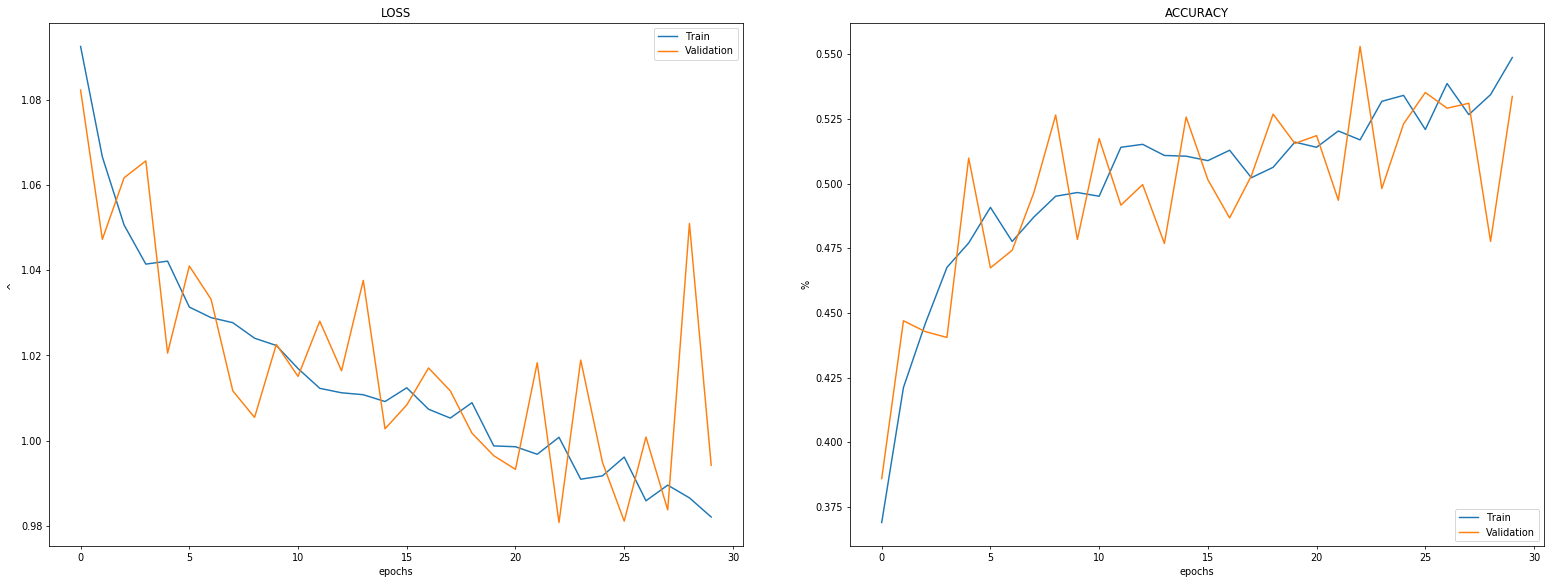

In [26]:
plotGraphs(M0_hist1)
plotGraphs(M0_hist2)
plotGraphs(M0_hist3)

### CNN - Version 1

In [27]:
class CNN(Classifier):   
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(    
            nn.Conv2d(3, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),  
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2,2),          
            
            nn.Flatten(),
            nn.Linear(2304,64),
            nn.ReLU(),           
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,3),
            nn.Softmax()
        )
        
    def forward(self, x):
        return self.layers(x);

In [28]:
cnn1 = CNN()
cnn2 = CNN()
cnn3 = CNN()

optimcnn1 = optim.SGD(cnn1.parameters(), lr=0.001)
optimcnn2 = optim.RMSprop(cnn2.parameters(), lr=0.001)
optimcnn3 = optim.Adam(cnn3.parameters(), lr=0.001)

In [29]:
hist_cnn1 = fitModel(N, cnn1, optimcnn1, train_dl, val_dl)

C:\Users\User\Documents\ANACONDA\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [1], train_loss: 1.0988, val_loss: 1.0988, train_acc: 0.3334, val_acc: 0.3333
Epoch [2], train_loss: 1.0987, val_loss: 1.0989, train_acc: 0.3343, val_acc: 0.3314
Epoch [3], train_loss: 1.0987, val_loss: 1.0988, train_acc: 0.3334, val_acc: 0.3333
Epoch [4], train_loss: 1.0987, val_loss: 1.0987, train_acc: 0.3329, val_acc: 0.3352
Epoch [5], train_loss: 1.0987, val_loss: 1.0988, train_acc: 0.3331, val_acc: 0.3314
Epoch [6], train_loss: 1.0986, val_loss: 1.0987, train_acc: 0.3337, val_acc: 0.3314
Epoch [7], train_loss: 1.0986, val_loss: 1.0986, train_acc: 0.3337, val_acc: 0.3352
Epoch [8], train_loss: 1.0986, val_loss: 1.0986, train_acc: 0.3337, val_acc: 0.3352
Epoch [9], train_loss: 1.0986, val_loss: 1.0987, train_acc: 0.3331, val_acc: 0.3352
Epoch [10], train_loss: 1.0986, val_loss: 1.0987, train_acc: 0.3331, val_acc: 0.3295
Epoch [11], train_loss: 1.0985, val_loss: 1.0987, train_acc: 0.3334, val_acc: 0.3314
Epoch [12], train_loss: 1.0985, val_loss: 1.0986, train_acc: 0.3331, val_a

In [30]:
hist_cnn2 = fitModel(N, cnn2, optimcnn2, train_dl, val_dl)

Epoch [1], train_loss: 1.0698, val_loss: 1.0321, train_acc: 0.4054, val_acc: 0.4538
Epoch [2], train_loss: 1.0065, val_loss: 1.0099, train_acc: 0.5089, val_acc: 0.4860
Epoch [3], train_loss: 0.9910, val_loss: 0.9696, train_acc: 0.5373, val_acc: 0.5515
Epoch [4], train_loss: 0.9764, val_loss: 0.9703, train_acc: 0.5522, val_acc: 0.5674
Epoch [5], train_loss: 0.9687, val_loss: 0.9518, train_acc: 0.5573, val_acc: 0.5765
Epoch [6], train_loss: 0.9586, val_loss: 1.0507, train_acc: 0.5771, val_acc: 0.4807
Epoch [7], train_loss: 0.9544, val_loss: 0.9510, train_acc: 0.5763, val_acc: 0.5795
Epoch [8], train_loss: 0.9520, val_loss: 0.9877, train_acc: 0.5777, val_acc: 0.5420
Epoch [9], train_loss: 0.9419, val_loss: 0.9374, train_acc: 0.5958, val_acc: 0.5947
Epoch [10], train_loss: 0.9441, val_loss: 1.1158, train_acc: 0.5851, val_acc: 0.4000
Epoch [11], train_loss: 0.9420, val_loss: 0.9333, train_acc: 0.5900, val_acc: 0.6027
Epoch [12], train_loss: 0.9298, val_loss: 0.9305, train_acc: 0.6035, val_a

In [31]:
hist_cnn3 = fitModel(N, cnn3, optimcnn3, train_dl, val_dl)

Epoch [1], train_loss: 1.0818, val_loss: 1.0161, train_acc: 0.3942, val_acc: 0.5163
Epoch [2], train_loss: 1.0136, val_loss: 0.9964, train_acc: 0.5020, val_acc: 0.5295
Epoch [3], train_loss: 0.9903, val_loss: 0.9913, train_acc: 0.5321, val_acc: 0.5258
Epoch [4], train_loss: 0.9762, val_loss: 0.9882, train_acc: 0.5522, val_acc: 0.5470
Epoch [5], train_loss: 0.9645, val_loss: 0.9692, train_acc: 0.5711, val_acc: 0.5587
Epoch [6], train_loss: 0.9520, val_loss: 1.0242, train_acc: 0.5780, val_acc: 0.4992
Epoch [7], train_loss: 0.9563, val_loss: 0.9723, train_acc: 0.5717, val_acc: 0.5629
Epoch [8], train_loss: 0.9417, val_loss: 0.9366, train_acc: 0.5932, val_acc: 0.5939
Epoch [9], train_loss: 0.9312, val_loss: 0.9240, train_acc: 0.6029, val_acc: 0.6045
Epoch [10], train_loss: 0.9274, val_loss: 0.9333, train_acc: 0.6141, val_acc: 0.5943
Epoch [11], train_loss: 0.9334, val_loss: 0.9306, train_acc: 0.6035, val_acc: 0.6008
Epoch [12], train_loss: 0.9200, val_loss: 0.9344, train_acc: 0.6144, val_a

In [32]:
M1_hist1 = pd.DataFrame(hist_cnn1)
M1_hist2 = pd.DataFrame(hist_cnn2)
M1_hist3 = pd.DataFrame(hist_cnn3)

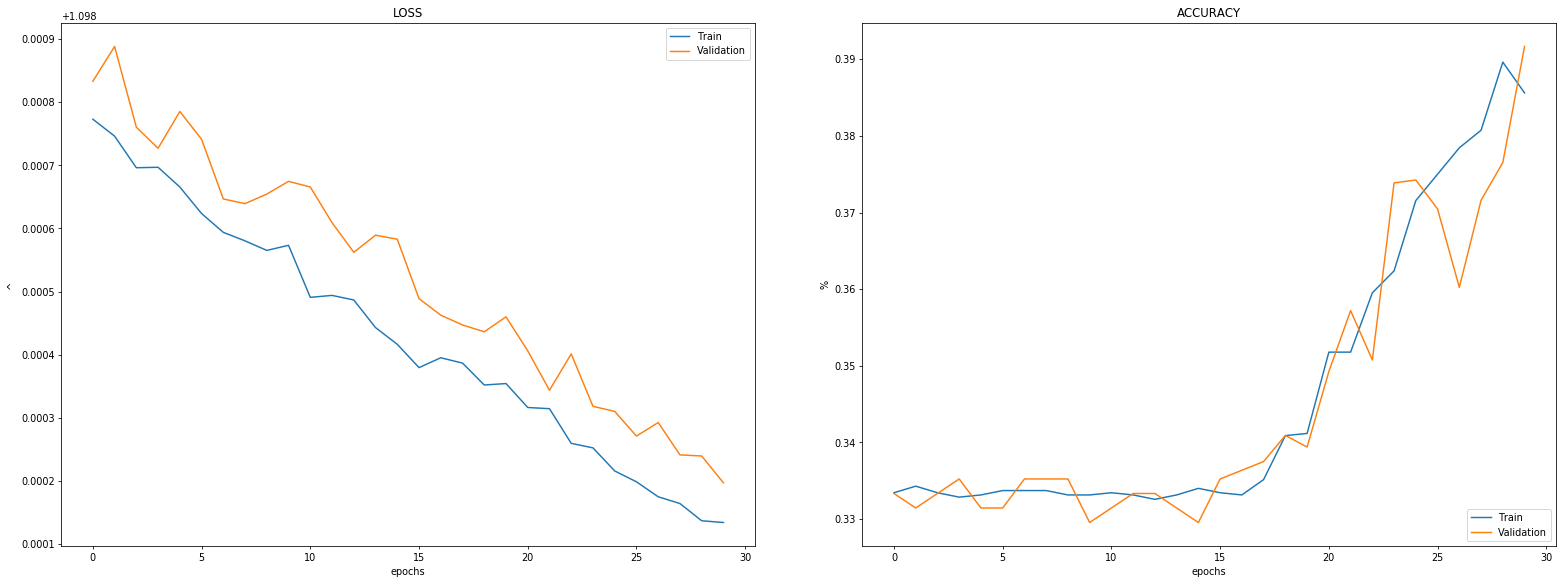

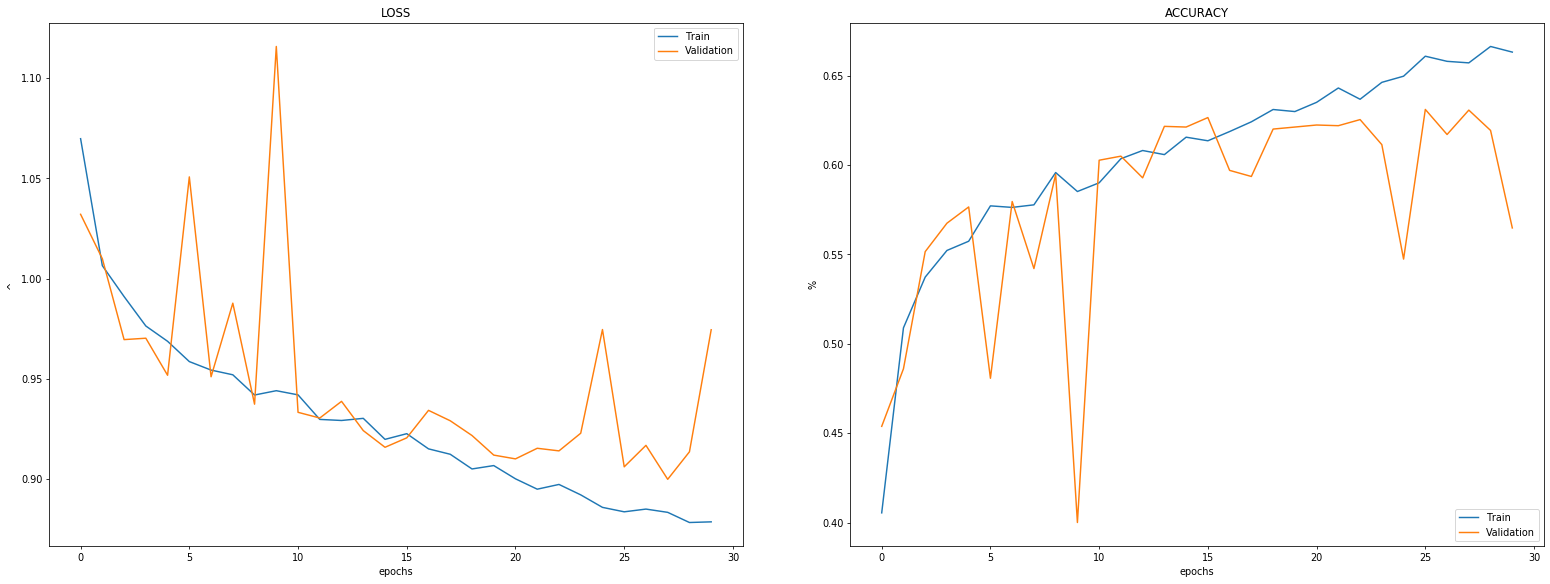

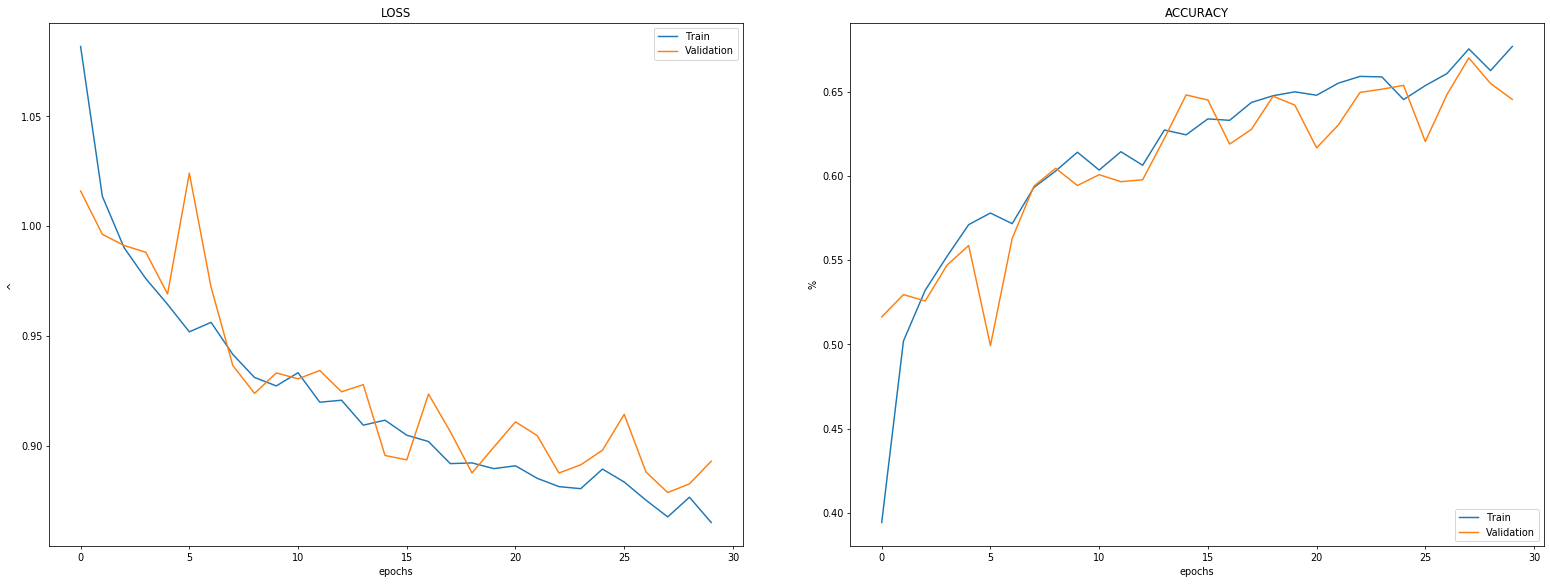

In [33]:
plotGraphs(M1_hist1)
plotGraphs(M1_hist2)
plotGraphs(M1_hist3)

### CNN - Version 2

In [34]:
class CNN1(Classifier):   
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(    
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, 3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 128, 3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2),
            
            nn.Flatten(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,3),
            nn.Softmax()
        )
        
    def forward(self, x):
        return self.layers(x);

In [35]:
CNN_V21 = CNN1()
CNN_V22 = CNN1()
CNN_V23 = CNN1()

optim_cnn21 = optim.Adam(CNN_V21.parameters(), lr=0.001)
optim_cnn22 = optim.Adam(CNN_V22.parameters(), lr=0.001)
optim_cnn23 = optim.Adam(CNN_V23.parameters(), lr=0.001)

train_dl1 = DataLoader(train_set, 32, shuffle=True)
train_dl2 = DataLoader(train_set, 16, shuffle=True)
train_dl3 = DataLoader(train_set, 8 , shuffle=True)
val_dl1   = DataLoader(val_set,   32, shuffle=True)
val_dl2   = DataLoader(val_set,   16, shuffle=True)
val_dl3   = DataLoader(val_set,   8 , shuffle=True)

In [36]:
hist21 = fitModel(N, CNN_V21, optim_cnn21, train_dl1, val_dl1)

C:\Users\User\Documents\ANACONDA\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [1], train_loss: 1.0984, val_loss: 1.0896, train_acc: 0.3265, val_acc: 0.3270
Epoch [2], train_loss: 1.0896, val_loss: 1.1016, train_acc: 0.3797, val_acc: 0.3344
Epoch [3], train_loss: 1.0581, val_loss: 1.0379, train_acc: 0.4366, val_acc: 0.4606
Epoch [4], train_loss: 1.0231, val_loss: 1.0164, train_acc: 0.4828, val_acc: 0.5056
Epoch [5], train_loss: 1.0005, val_loss: 0.9932, train_acc: 0.5161, val_acc: 0.5409
Epoch [6], train_loss: 1.0000, val_loss: 0.9749, train_acc: 0.5201, val_acc: 0.5372
Epoch [7], train_loss: 0.9829, val_loss: 0.9747, train_acc: 0.5444, val_acc: 0.5491
Epoch [8], train_loss: 0.9740, val_loss: 0.9795, train_acc: 0.5477, val_acc: 0.5379
Epoch [9], train_loss: 0.9648, val_loss: 0.9695, train_acc: 0.5667, val_acc: 0.5681
Epoch [10], train_loss: 0.9633, val_loss: 0.9548, train_acc: 0.5678, val_acc: 0.5748
Epoch [11], train_loss: 0.9463, val_loss: 0.9553, train_acc: 0.5851, val_acc: 0.5688
Epoch [12], train_loss: 0.9468, val_loss: 0.9565, train_acc: 0.5817, val_a

In [37]:
hist22 = fitModel(N, CNN_V22, optim_cnn22, train_dl2, val_dl2)

Epoch [1], train_loss: 1.0993, val_loss: 1.0986, train_acc: 0.3260, val_acc: 0.3333
Epoch [2], train_loss: 1.0991, val_loss: 1.0974, train_acc: 0.3320, val_acc: 0.3333
Epoch [3], train_loss: 1.0978, val_loss: 1.0988, train_acc: 0.3392, val_acc: 0.3371
Epoch [4], train_loss: 1.0960, val_loss: 1.1277, train_acc: 0.3541, val_acc: 0.3508
Epoch [5], train_loss: 1.0495, val_loss: 1.0129, train_acc: 0.4438, val_acc: 0.4845
Epoch [6], train_loss: 1.0255, val_loss: 1.0006, train_acc: 0.4771, val_acc: 0.5269
Epoch [7], train_loss: 0.9970, val_loss: 0.9896, train_acc: 0.5097, val_acc: 0.5239
Epoch [8], train_loss: 0.9871, val_loss: 0.9769, train_acc: 0.5229, val_acc: 0.5451
Epoch [9], train_loss: 0.9870, val_loss: 0.9758, train_acc: 0.5295, val_acc: 0.5386
Epoch [10], train_loss: 0.9832, val_loss: 0.9712, train_acc: 0.5430, val_acc: 0.5621
Epoch [11], train_loss: 0.9670, val_loss: 0.9578, train_acc: 0.5622, val_acc: 0.5640
Epoch [12], train_loss: 0.9612, val_loss: 0.9429, train_acc: 0.5700, val_a

In [38]:
hist23 = fitModel(N, CNN_V23, optim_cnn23, train_dl3, val_dl3)

Epoch [1], train_loss: 1.0992, val_loss: 1.0988, train_acc: 0.3213, val_acc: 0.3341
Epoch [2], train_loss: 1.0989, val_loss: 1.0987, train_acc: 0.3368, val_acc: 0.3337
Epoch [3], train_loss: 1.0989, val_loss: 1.0987, train_acc: 0.3213, val_acc: 0.3333
Epoch [4], train_loss: 1.0989, val_loss: 1.0987, train_acc: 0.3250, val_acc: 0.3330
Epoch [5], train_loss: 1.0988, val_loss: 1.0986, train_acc: 0.3213, val_acc: 0.3333
Epoch [6], train_loss: 1.0988, val_loss: 1.0986, train_acc: 0.3126, val_acc: 0.3333
Epoch [7], train_loss: 1.0988, val_loss: 1.0986, train_acc: 0.3348, val_acc: 0.3337
Epoch [8], train_loss: 1.0988, val_loss: 1.0986, train_acc: 0.3241, val_acc: 0.3330
Epoch [9], train_loss: 1.0988, val_loss: 1.0986, train_acc: 0.3198, val_acc: 0.3330
Epoch [10], train_loss: 1.0988, val_loss: 1.0986, train_acc: 0.3138, val_acc: 0.3333
Epoch [11], train_loss: 1.0988, val_loss: 1.0986, train_acc: 0.3273, val_acc: 0.3330
Epoch [12], train_loss: 1.0988, val_loss: 1.0986, train_acc: 0.3201, val_a

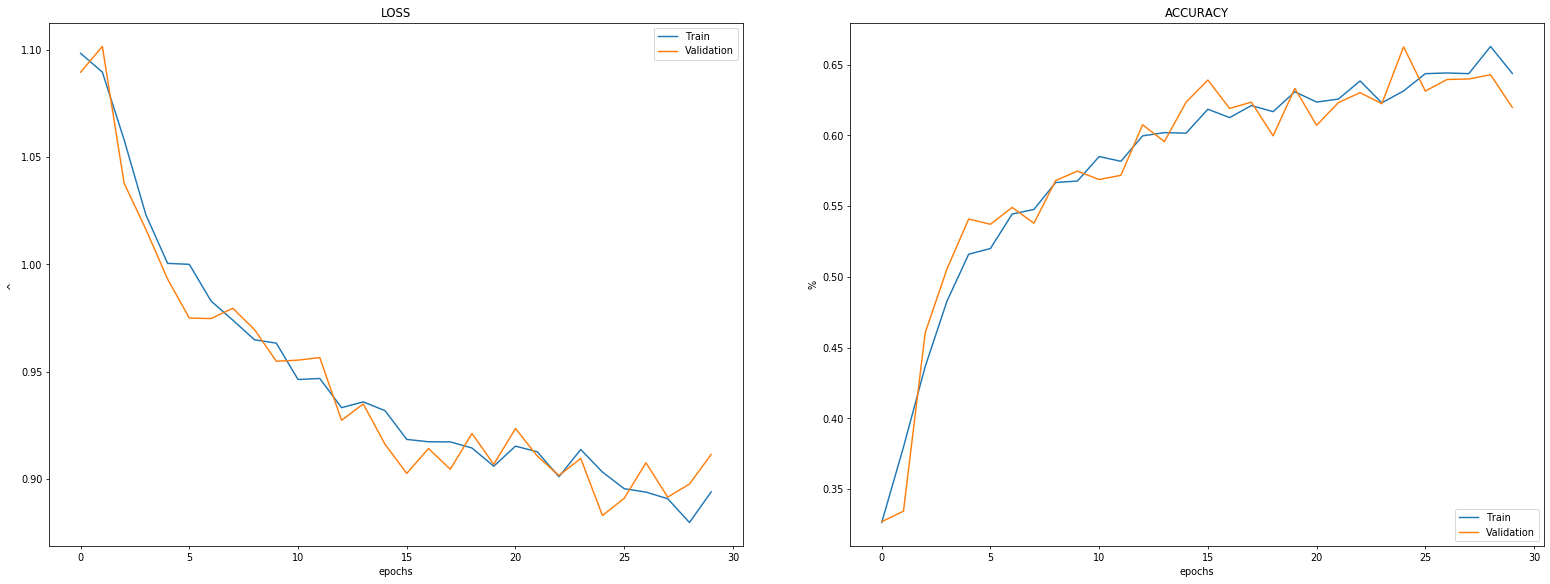

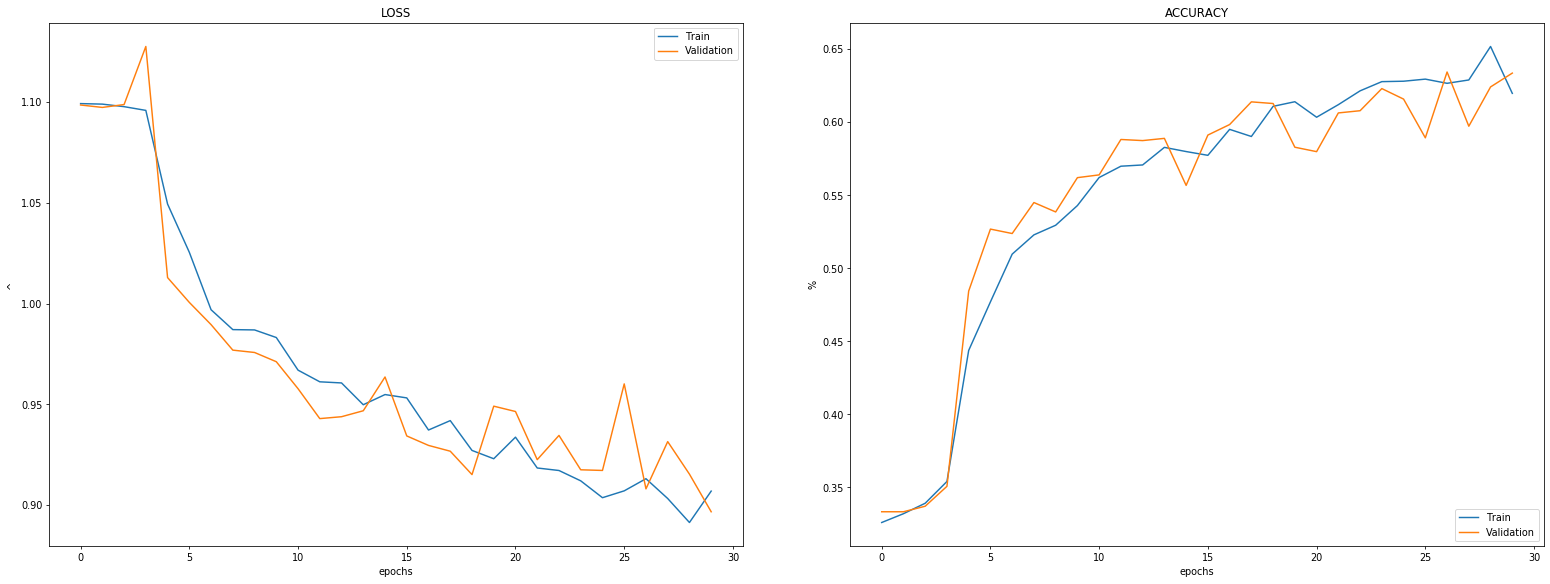

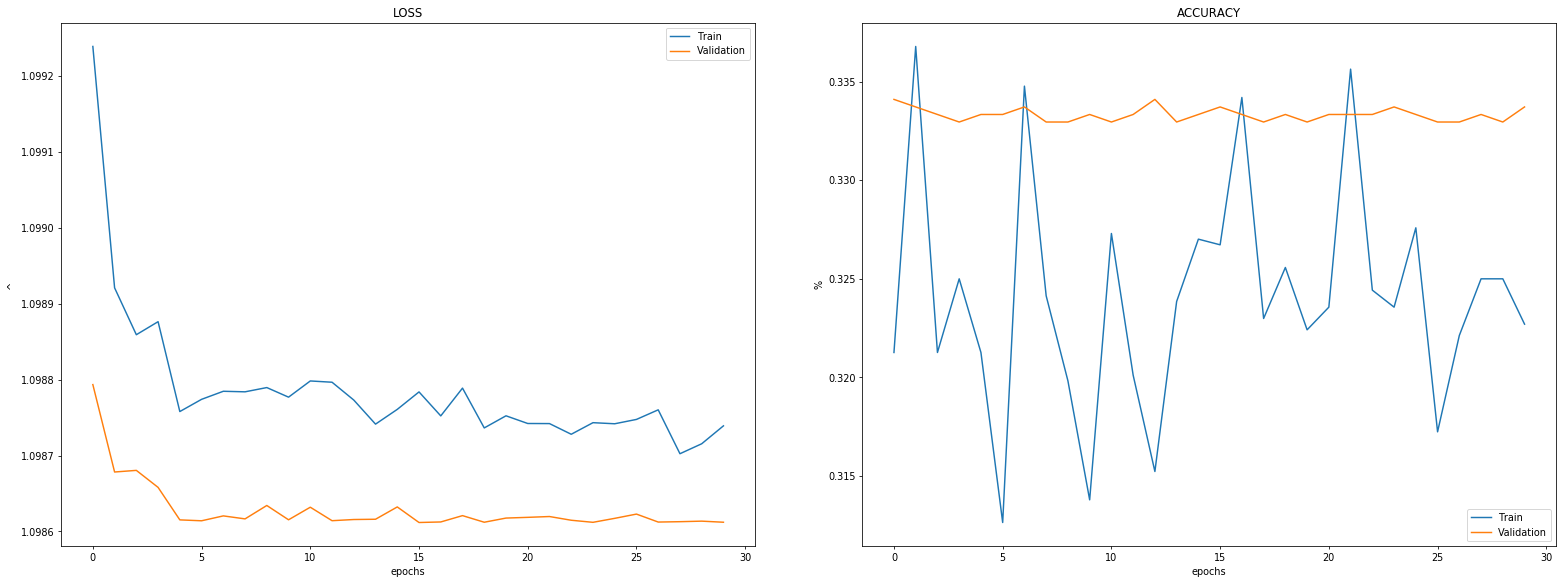

In [39]:
M2_hist1 = pd.DataFrame(hist21)
M2_hist2 = pd.DataFrame(hist22)
M2_hist3 = pd.DataFrame(hist23)

plotGraphs(M2_hist1)
plotGraphs(M2_hist2)
plotGraphs(M2_hist3)

### Final model

In [42]:
class CNN_final(Classifier):   
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(    
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
        
            nn.Conv2d(64, 128, 3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            
            nn.Conv2d(128, 128, 3,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(0.2),
            
            nn.Flatten(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Dropout(0.4),
            
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,3),
            nn.Softmax()
        )
        
    def forward(self, x):
        return self.layers(x);

In [43]:
CNN_Final = CNN_final()

optim_cnn_final = optim.Adam(CNN_Final.parameters(), lr=0.001)



train_dl_final = DataLoader(train_set, 16, shuffle=True)
val_dl_final   = DataLoader(val_set,   16, shuffle=True)


In [44]:
hist_final = fitModel(N, CNN_Final, optim_cnn_final, train_dl_final, val_dl_final)

C:\Users\User\Documents\ANACONDA\lib\site-packages\torch\nn\modules\container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch [1], train_loss: 1.0983, val_loss: 1.0985, train_acc: 0.3423, val_acc: 0.3314
Epoch [2], train_loss: 1.0938, val_loss: 1.0965, train_acc: 0.3535, val_acc: 0.3367
Epoch [3], train_loss: 1.0561, val_loss: 1.0114, train_acc: 0.4395, val_acc: 0.4947
Epoch [4], train_loss: 1.0074, val_loss: 0.9915, train_acc: 0.4991, val_acc: 0.5379
Epoch [5], train_loss: 0.9920, val_loss: 1.0028, train_acc: 0.5292, val_acc: 0.4936
Epoch [6], train_loss: 0.9793, val_loss: 0.9664, train_acc: 0.5404, val_acc: 0.5720
Epoch [7], train_loss: 0.9849, val_loss: 0.9801, train_acc: 0.5364, val_acc: 0.5648
Epoch [8], train_loss: 0.9668, val_loss: 0.9532, train_acc: 0.5634, val_acc: 0.5686
Epoch [9], train_loss: 0.9667, val_loss: 0.9499, train_acc: 0.5599, val_acc: 0.5754
Epoch [10], train_loss: 0.9543, val_loss: 0.9660, train_acc: 0.5806, val_acc: 0.5708
Epoch [11], train_loss: 0.9455, val_loss: 0.9545, train_acc: 0.5808, val_acc: 0.5606
Epoch [12], train_loss: 0.9330, val_loss: 0.9911, train_acc: 0.5992, val_a

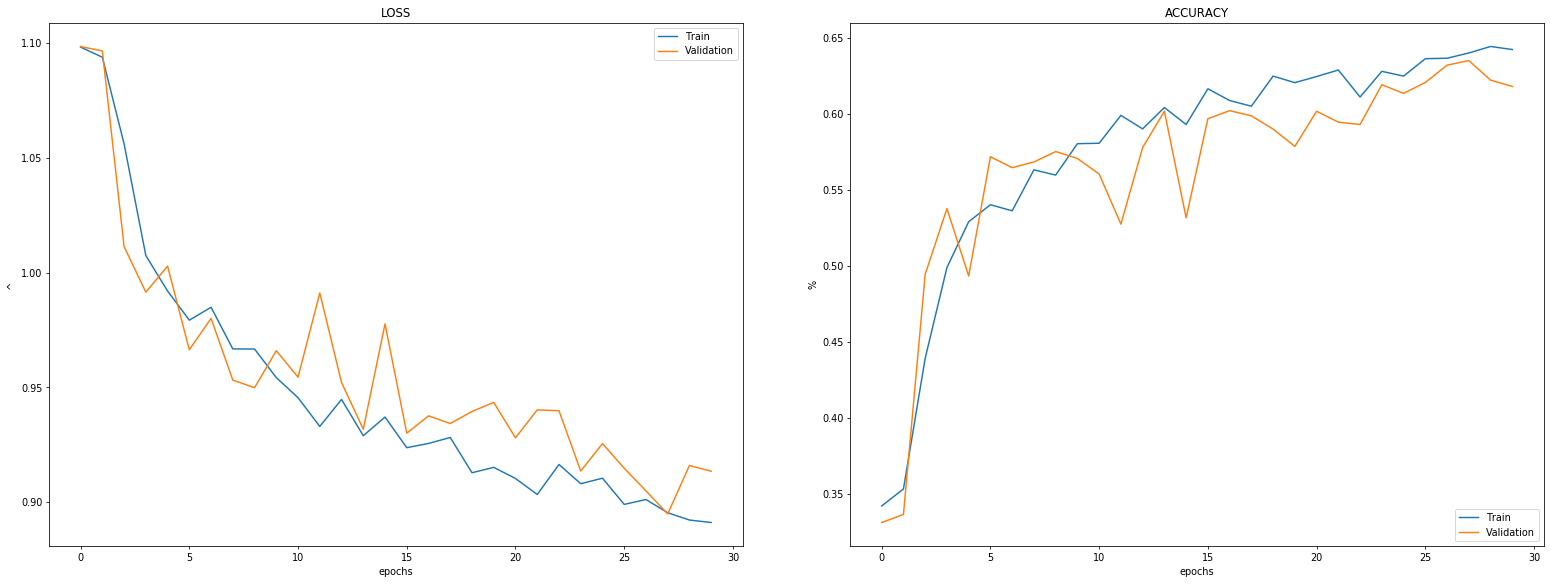

In [45]:
plotGraphs(pd.DataFrame(hist_final))

### Saving

In [46]:
torch.save(CNN_Final .state_dict(), "model.pth")